In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"

import jax
import jax.numpy as jnp
import numpy as np
from scipy.signal import fftconvolve, convolve2d
from scipy.ndimage import rotate
from utils.winnie_class import WinniePSF
from winnie_jwst_fm import generate_nircam_psf_grid
import webbpsf_ext
import matplotlib.pyplot as plt

/home/mihirkondapalli/anaconda3/envs/jwst_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).


### Creating example instrument

In [2]:
# cent = np.array([148.9, 173.4]) # Position of aligned stars in the data (where I shifted to place the star at the nominal coronagraph center for NIRCam F335M) 
# 0.078-0.531
cent = np.array([148.9+0.078, 173.4-0.531])

dc_rolls = np.array([[0,0],[0,0]]) # Offset between the star and the coronagraph center for each roll in pixels. No offset for this example.

c_coron_rolls = cent + dc_rolls

fov_pix = 153 # The detector-sampled FOV size for PSFs. You probably want something a bit larger than is used for point sources
osamp = 2 # The oversampling factor for PSFs (and models eventually)

source_spectrum = None

inst = webbpsf_ext.NIRCam_ext(fov_pix=fov_pix, oversample=osamp)

inst.options['pupil_shift_x'] = -0.012
inst.options['pupil_shift_y'] = -0.008
inst.options['defocus_waves'] = -0.00865
inst.options['pupil_rotation'] = -0.595
inst.gen_psf_coeff()
inst.gen_wfemask_coeff(large_grid=True)

print("Generating PSFs")
# # Generate our grid of PSFs and maps of throughput and of pixel matches to the sampled PSFs
psfs, psf_inds_rolls, im_mask_rolls, psf_offsets = generate_nircam_psf_grid(inst, c_coron_rolls, source_spectrum=source_spectrum, normalize=True,
                                                                            log_rscale=True, nr=5, rmax=10**0.5, ntheta=4, use_coeff=True)

nircam_psf_list_ex = [psfs, psf_inds_rolls, im_mask_rolls, psf_offsets]

Generating PSFs


### Creating actual instrument

In [3]:
#############################################
######### Read in NIRCam model PSFs #########
#############################################

x1 = 0
x2 = 4096
y1 = 0
y2 = 4096

##################### F300M #################
psf_dir = "for_mihir_20241218/F300M/"
psf_suffixes = "_F300M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list_f300m = [psfs,psf_inds_rolls,im_mask_rolls,unique_inds]

psf_dir = "for_mihir_20241218/F360M/"
psf_suffixes = "_F360M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list_f360m = [psfs,psf_inds_rolls,im_mask_rolls,unique_inds]

In [4]:
psfs, psf_inds_rolls, im_mask_rolls, psf_offsets = nircam_psf_list_f300m

### Creating test image and parangs

In [5]:
from utils.disk_utils_jax import jax_model_winnie
import scipy

In [6]:
# Imports

from utils.disk_utils_jax import jax_model
# Dust Distribution Function
from utils.SLD_utils import DustEllipticalDistribution2PowerLaws
# Scattering Phase Functions
from utils.SLD_utils import HenyeyGreenstein_SPF, DoubleHenyeyGreenstein_SPF, InterpolatedUnivariateSpline_SPF, GAUSSIAN_PSF

In [7]:
# Parameters
disk_params = {}
disk_params['inclination'] = 40. #In degrees
disk_params['position_angle'] = 50. #In Degrees
disk_params['alpha_in'] = 5. #The inner power law
disk_params['alpha_out'] = -5. #The outer power law
disk_params['flux_scaling'] = 1e6
disk_params['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [8]:
# This depends on the function
#spf_params_HG = HenyeyGreenstein_SPF.params   # Gets default parameters: {'g', 0.3}
#spf_params_DHG = DoubleHenyeyGreenstein_SPF.params
spf_params_IUS = InterpolatedUnivariateSpline_SPF.params

#disk_image_HG = jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params, spf_params_HG)
#disk_image_DHG = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params, spf_params_DHG)
disk_image_IUS = jax_model(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params, spf_params_IUS)

In [9]:
test_image = disk_image_IUS + np.random.normal(scale=1, size=(140, 140))  # Added noise

test_parangs = jnp.unique(np.linspace(-45, 45, 8))

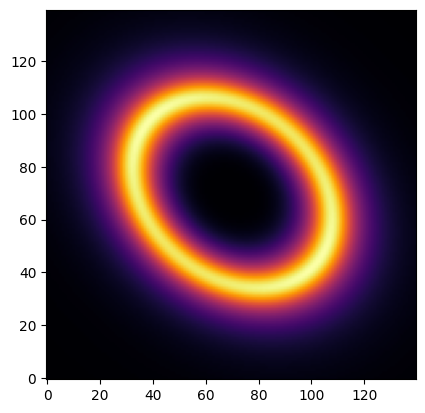

In [10]:
plt.imshow(disk_image_IUS, origin='lower', cmap='inferno')

### Initializing WinniePSF and running get_convolved_cube()

In [11]:
#psfs, psf_inds_rolls, im_mask_rolls, psf_offsets = nircam_psf_list_ex
#winnie_psf_ex = WinniePSF(psfs=psfs, psf_inds_rolls=psf_inds_rolls, im_mask_rolls=im_mask_rolls, psf_offsets=psf_offsets)
#convolved_cube_ex = winnie_psf_ex.get_convolved_cube(test_image, test_parangs)

psfs, psf_inds_rolls, im_mask_rolls, psf_offsets = nircam_psf_list_f300m
winnie_psf_F300M = WinniePSF(psfs=psfs, psf_inds_rolls=psf_inds_rolls, im_mask_rolls=im_mask_rolls, psf_offsets=psf_offsets, psf_parangs=test_parangs,
                             num_unique_psfs=46)

convolved_image = jax_model_winnie(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params, spf_params_IUS, winnie_psf_F300M)

#psfs, psf_inds_rolls, im_mask_rolls, psf_offsets = nircam_psf_list_f360m
#winnie_psf_F360M = WinniePSF(psfs=psfs, psf_inds_rolls=psf_inds_rolls, im_mask_rolls=im_mask_rolls, psf_offsets=psf_offsets)
#convolved_cube_F360M = winnie_psf_F360M.get_convolved_cube(test_image, test_parangs)

### Results

Text(0.5, 1.0, 'F300M PSF Convolution')

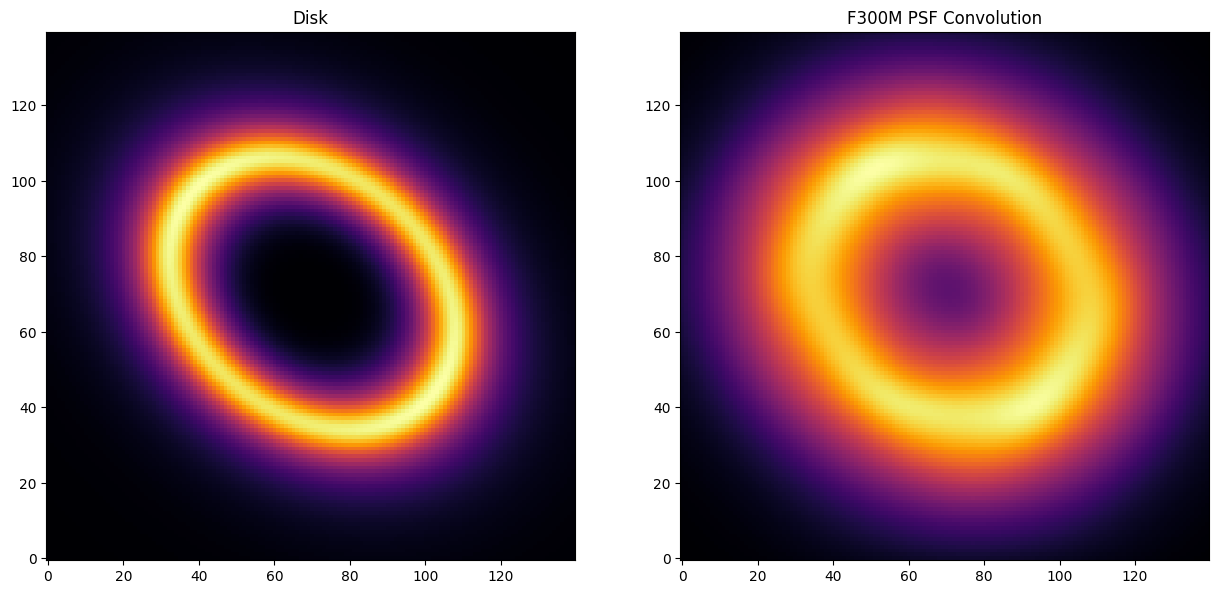

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

plt.title("WebbPSF Convolutions")

axes[0].imshow(disk_image_IUS, cmap='inferno', origin='lower')
axes[0].set_title("Disk")

axes[1].imshow(convolved_image, cmap = 'inferno', origin='lower')
axes[1].set_title("F300M PSF Convolution")

### Jaxing Winnie Convolution

In [13]:
jaxed_convolution = jax.jit(winnie_psf_F300M.get_convolved_cube)
temp = jaxed_convolution(disk_image_IUS)

In [14]:
%timeit winnie_psf_F300M.get_convolved_cube(disk_image_IUS)

357 ms ± 544 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit jaxed_convolution(disk_image_IUS)

11.2 ms ± 1.65 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Using a Dynamic PSF

In [16]:
# Calculating Log Likelihood

from utils.disk_utils_jax import jax_model_all_1d_cent_winnie
from utils.regression import log_likelihood_1d_pos_cent_winnie

In [17]:
# Parameters
disk_params = {}
disk_params['inclination'] = 40. #In degrees
disk_params['position_angle'] = 50. #In Degrees
disk_params['alpha_in'] = 5. #The inner power law
disk_params['alpha_out'] = -5. #The outer power law
disk_params['flux_scaling'] = 1e6
disk_params['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

Text(0.5, 1.0, 'Initial Disk')

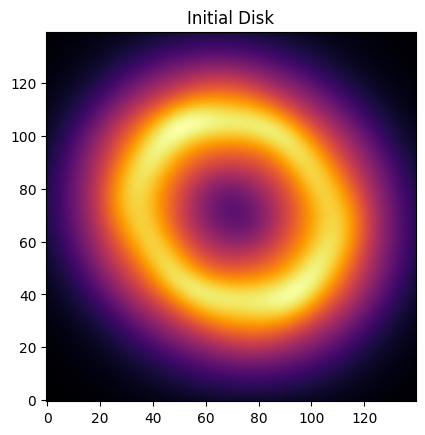

In [18]:
spline_params_1d= jnp.full(6, 0.05)
disk_params_1d = np.array([disk_params['alpha_in'], disk_params['alpha_out'], disk_params['sma'], disk_params['inclination'],
                           disk_params['position_angle']]) # have to put values in this specific order (flux scaling is not included in the array)

disk_image = jax_model_winnie(DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, disk_params, spline_params_1d,
                             winnie_psf_F300M)

plt.imshow(disk_image, origin='lower', cmap='inferno')
plt.title("Initial Disk")

#### Fitting for a disk

Text(0.5, 1.0, 'Noisy Target Disk')

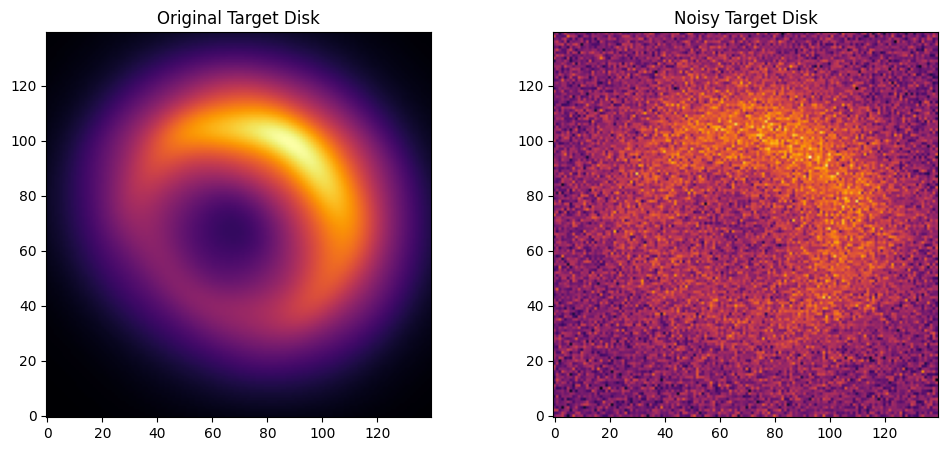

In [19]:
# Parameters
target_disk_params = {}
target_disk_params['inclination'] = 60. #In degrees
target_disk_params['position_angle'] = 30. #In Degrees
target_disk_params['alpha_in'] = 6. #The inner power law
target_disk_params['alpha_out'] = -7. #The outer power law
target_disk_params['flux_scaling'] = 1e6
target_disk_params['sma'] = 50. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

target_spf_params = {'g1': 0.2, 'g2': 0.5, 'weight': 0.45}

# Target Disk Model Image
target_image_orig = jax_model_winnie(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params, target_spf_params,
                                     winnie_psf_F300M)
noise_level = 50
noise = np.random.normal(0, noise_level, target_image_orig.shape)
target_image = target_image_orig + noise
err_map = jnp.ones(target_image_orig.shape)*noise_level

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(target_image_orig, origin='lower', cmap='inferno')
axes[0].set_title('Original Target Disk')
axes[1].imshow(target_image, origin='lower', cmap='inferno')
axes[1].set_title('Noisy Target Disk')

In [20]:
%timeit jax_model_winnie(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params, target_spf_params, winnie_psf_F300M)

11.4 ms ± 2.95 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
cent_array = np.array([70, 70])
all_pars_cent_spline = jnp.concatenate([cent_array, disk_params_1d, spline_params_1d])

print(log_likelihood_1d_pos_cent_winnie(all_pars_cent_spline, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF,
                                        winnie_psf_F300M, disk_params['flux_scaling'], target_image, err_map))

91895.8


In [22]:
len_disk_params = 7
llp = lambda x: log_likelihood_1d_pos_cent_winnie(x,
                                                      DustEllipticalDistribution2PowerLaws,
                                                      InterpolatedUnivariateSpline_SPF,
                                                      winnie_psf_F300M, disk_params['flux_scaling'],
                                                      target_image, err_map)

soln = scipy.optimize.minimize(llp, all_pars_cent_spline)

In [23]:
print(soln.x)
print(soln.fun)

[ 7.e+01  7.e+01  5.e+00 -5.e+00  3.e+01  4.e+01  5.e+01  5.e-02  5.e-02
  5.e-02  5.e-02  5.e-02  5.e-02]
91895.796875
